In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter
titlefontsize = 13
labelfontsize = 14
legendfontsize = 13
labelpad = 10
savedir = "."

In [2]:
#############################################################
########## Initial run with original parameters #############
#############################################################


input_data = np.load("./MLtrack_data/rf_data/mese_saved_arrays_with_predictions.npy")
#rf_pred = input_data[:,2+3+3]; rf_true = input_data[:,2]  # enu 
#rf_pred = input_data[:,0+3+3]; rf_true = input_data[:,0]  # ehad 
#rf_pred = input_data[:,1+3+3]; rf_true = input_data[:,1]  # emu 
#print(rf_pred, rf_true)
print(input_data)

[[9.32386957e+04 1.10550258e+06 1.19874127e+06 ... 9.60042270e+04
  1.80190090e+05 2.39322539e-08]
 [6.81762793e+04 3.27990141e+05 3.96166421e+05 ... 3.06213497e+04
  8.92404838e+04 3.97895490e-09]
 [5.44004635e+04 3.34085479e+05 3.88485942e+05 ... 2.32254220e+04
  6.59246928e+04 3.26772692e-09]
 ...
 [4.30764400e+04 1.38225742e+06 1.42533386e+06 ... 4.30165519e+04
  6.84398346e+04 1.97475331e-08]
 [1.70360988e+04 3.14644386e+06 3.16347996e+06 ... 1.21921973e+05
  1.34664597e+05 4.51943874e-08]
 [3.88386785e+05 8.03967596e+05 1.19235438e+06 ... 4.39365053e+04
  2.37366896e+05 2.46991691e-08]]


In [3]:
enu_pred = input_data[:,2+3+3]; enu_true = input_data[:,2]; enu_ratio = (enu_pred-enu_true)/enu_true
ehad_pred = input_data[:,0+3+3]; ehad_true = input_data[:,0]; ehad_ratio = (ehad_pred-ehad_true)/ehad_true
emu_pred = input_data[:,1+3+3]; emu_true = input_data[:,1]; emu_ratio = (emu_pred-emu_true)/emu_true

In [4]:
energy_slices = np.logspace(3,7,81)
energy_centers = 0.5*(energy_slices[1:] + energy_slices[:-1])
print(energy_slices.shape)
print(energy_centers.shape)

(81,)
(80,)


In [5]:
# compute quantiles

def calculate_quantile(hist, bins, q=0.5):  
    total = np.sum(hist)
    qtile = total * q 

    num = 0; num_low = 0; num_high = 0 
    qbin_low = 0; qbin_high = 0 

    for i in range(len(hist)): 
        num_low = num 
        num += hist[i]
        num_high = num 

        if num > qtile: 
            qbin_low = i - 1 
            qbin_high = i 
            break 
    
    qbin = qbin_low + (qbin_high-qbin_low)*(qtile-num_low)/(num_high-num_low)
    hist_quantile = bins[qbin_low] + (bins[qbin_high]-bins[qbin_low])*(qtile-num_low)/(num_high-num_low) 

    return hist_quantile

In [6]:
trans_rates_in_2D, new_xbins, new_ybins = np.histogram2d(enu_true, enu_pred, 
                                                         weights=np.ones(len(enu_pred))/len(enu_pred),
                                                         bins=[energy_slices,energy_slices])
rates_in_2D = trans_rates_in_2D.T

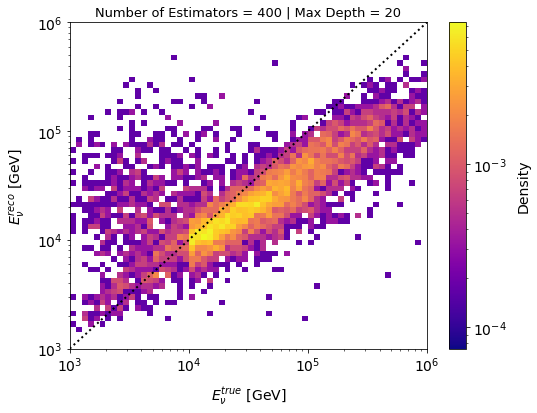

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

im = ax.pcolormesh(new_xbins, new_ybins, rates_in_2D, 
                   cmap=plt.cm.get_cmap("plasma"), 
                   norm=LogNorm(vmin=1e-2*np.amax(rates_in_2D), vmax=np.amax(rates_in_2D)))
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Density", fontsize=labelfontsize, labelpad=labelpad)
cbar.ax.tick_params(labelsize=labelfontsize)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10**3,10**6)
ax.set_ylim(10**3,10**6)

ax.set_title("Number of Estimators = 400 | Max Depth = 20", fontsize=titlefontsize)
ax.set_xlabel(r"$E_{\nu}^{true}$ [GeV]", fontsize=labelfontsize, labelpad=labelpad)
ax.set_ylabel(r"$E_{\nu}^{reco}$ [GeV]", fontsize=labelfontsize, labelpad=labelpad)

x = np.arange(energy_slices[0], energy_slices[-1], 10)
y = x
ax.plot(x, y, linestyle="dotted", linewidth=2.0, color="black")

plt.tick_params(labelsize=labelfontsize)

plt.savefig("rf_energy_performance_predictions_n400_md_20.png")

In [8]:
ratio_slices = np.linspace(-3,3,121)
ratio_centers = 0.5*(ratio_slices[1:] + ratio_slices[:-1])

trans_rates_in_2D, new_xbins, new_ybins = np.histogram2d(enu_true, enu_ratio, 
                                                         weights=np.ones(len(enu_pred))/len(enu_pred),
                                                         bins=[energy_slices,ratio_slices])
rates_in_2D = trans_rates_in_2D.T

/tmp/ipykernel_1745/2288584009.py:20: RuntimeWarning: invalid value encountered in double_scalars
  qbin = qbin_low + (qbin_high-qbin_low)*(qtile-num_low)/(num_high-num_low)
/tmp/ipykernel_1745/2288584009.py:21: RuntimeWarning: invalid value encountered in double_scalars
  hist_quantile = bins[qbin_low] + (bins[qbin_high]-bins[qbin_low])*(qtile-num_low)/(num_high-num_low)


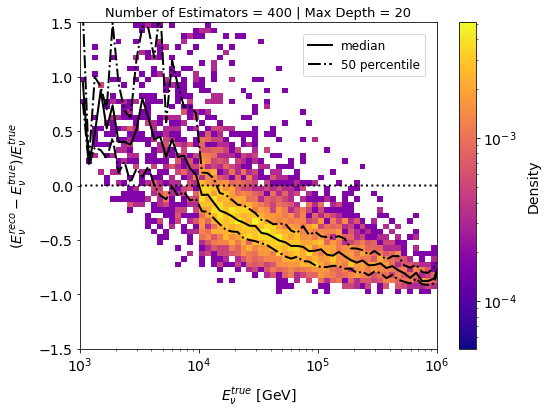

In [9]:
median = []; phalf = []; mhalf = [] 
for i in range(len(energy_centers)): 
    hist_ratio_1d = trans_rates_in_2D[i]
    median.append(calculate_quantile(hist_ratio_1d, ratio_centers, q=0.5))
    phalf.append(calculate_quantile(hist_ratio_1d, ratio_centers, q=0.75))
    mhalf.append(calculate_quantile(hist_ratio_1d, ratio_centers, q=0.25))

median = np.array(median, dtype=float)
phalf = np.array(phalf, dtype=float)
mhalf = np.array(mhalf, dtype=float)


fig, ax = plt.subplots(1, 1, figsize=(8,6))

im = ax.pcolormesh(new_xbins, new_ybins, rates_in_2D, 
                   cmap=plt.cm.get_cmap("plasma"), 
                   norm=LogNorm(vmin=1e-2*np.amax(rates_in_2D), vmax=np.amax(rates_in_2D)))
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Density", fontsize=labelfontsize, labelpad=labelpad)
cbar.ax.tick_params(labelsize=labelfontsize)

ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlim(10**3,10**6)
ax.set_ylim(-1.5,1.5)

ax.set_title("Number of Estimators = 400 | Max Depth = 20", fontsize=titlefontsize)
ax.set_xlabel(r"$E_{\nu}^{true}$ [GeV]", fontsize=labelfontsize, labelpad=labelpad)
ax.set_ylabel(r"$(E_{\nu}^{reco}-E_{\nu}^{true})/E_{\nu}^{true}$", fontsize=labelfontsize, labelpad=labelpad)

x = np.arange(energy_slices[0], energy_slices[-1], 10)
y = np.zeros(len(x))
ax.plot(x, y, linestyle="dotted", linewidth=2.0, color="black")

ax.plot(energy_centers, median, linestyle="solid", linewidth=2.0, color="black", label="median")
ax.plot(energy_centers, phalf, linestyle="dashdot", linewidth=2.0, color="black", label="50 percentile")
ax.plot(energy_centers, mhalf, linestyle="dashdot", linewidth=2.0, color="black")

ax.legend(bbox_to_anchor=(1,1), loc="upper right", borderaxespad=1, fontsize=legendfontsize-1)
plt.tick_params(labelsize=labelfontsize)

plt.savefig("stats_predictions_n400_md_20.png")

In [ ]:
median = []; phalf = []; mhalf = [] 
for i in range(len(energy_centers)): 
    hist_ratio_1d = trans_rates_in_2D[i]
    median.append(calculate_quantile(hist_ratio_1d, ratio_centers, q=0.5))
    phalf.append(calculate_quantile(hist_ratio_1d, ratio_centers, q=0.75))
    mhalf.append(calculate_quantile(hist_ratio_1d, ratio_centers, q=0.25))

median = np.array(median, dtype=float)
phalf = np.array(phalf, dtype=float)
mhalf = np.array(mhalf, dtype=float)


fig, ax = plt.subplots(1, 1, figsize=(8,6))

cbar.ax.tick_params(labelsize=labelfontsize)

ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlim(10**3,10**6)
ax.set_ylim(-1.5,1.5)

ax.set_title("Number of Estimators = 800 | Max Depth = 20", fontsize=titlefontsize)
ax.set_xlabel(r"$E_{\nu}^{true}$ [GeV]", fontsize=labelfontsize, labelpad=labelpad)
ax.set_ylabel(r"$(E_{\nu}^{reco}-E_{\nu}^{true})/E_{\nu}^{true}$", fontsize=labelfontsize, labelpad=labelpad)

x = np.arange(energy_slices[0], energy_slices[-1], 10)
y = np.zeros(len(x))
ax.plot(x, y, linestyle="dotted", linewidth=2.0, color="black")

#ax.plot(energy_centers, median, linestyle="solid", linewidth=2.0, color="black", label="median")
ax.plot(energy_centers, phalf, linestyle="dashdot", linewidth=2.0, color="black", label="50 percentile")
#ax.plot(energy_centers, mhalf, linestyle="dashdot", linewidth=2.0, color="black")

ax.legend(bbox_to_anchor=(1,1), loc="upper right", borderaxespad=1, fontsize=legendfontsize-1)
plt.tick_params(labelsize=labelfontsize)

In [ ]:
mu = 0.0
sigma = 10

data = np.random.normal(mu, sigma, 1000)

count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()


In [ ]:
print(bins)

In [ ]:
count.shape

In [ ]:
bins.shape

In [ ]:
## calculate median ##

def calc_quantile(count, bins, q):
    if q > 1 or q < 0:
        return "ERROR: q should be 0 to 1"
        
    total = 0
    median = bins[0]
    half_sum = (sum(count)) * q
    
    for i in range(len(count)):
        total += count[i]
        if total >= half_sum:
            median = bins[i]
            break
    
            
    return median


In [ ]:
print(calc_quantile(count, bins, q=0.5))
print(calc_quantile(count, bins, q=0.25))
print(calc_quantile(count, bins, q=0.75))
print(calc_quantile(count, bins, q=0))
print(calc_quantile(count, bins, q=100))

In [ ]:
def calc_hist_quantile(hist, bins, q=0.5):  
    total = np.sum(hist)
    qtile = total * q 

    num = 0; num_low = 0; num_high = 0 
    qbin_low = 0; qbin_high = 0 

    for i in range(len(hist)): 
        num_low = num 
        num += hist[i]
        num_high = num 

        if num > qtile: 
            qbin_low = i - 1 
            qbin_high = i 
            break 
    
    qbin = qbin_low + (qbin_high-qbin_low)*(qtile-num_low)/(num_high-num_low)
    hist_quantile = bins[qbin_low] + (bins[qbin_high]-bins[qbin_low])*(qtile-num_low)/(num_high-num_low)
        # maybe need to be modified for log x case 

    return hist_quantile

In [ ]:
##############################
########## medians ###########
##############################


input_data_400 = np.load("./MLtrack_data/rf_data/mese_saved_arrays_with_predictions_n400_md_100.npy")
input_data_800 = np.load("./MLtrack_data/rf_data/mese_saved_arrays_with_predictions_n800_md_100.npy")
input_data_10 = np.load("./MLtrack_data/rf_data/mese_saved_arrays_with_predictions_n1000_md_100.npy")


In [ ]:
enu_pred_400 = input_data_400[:,2+3+3]; enu_true_400 = input_data_400[:,2]; enu_ratio_400 = (enu_pred_400-enu_true_400)/enu_true_400
ehad_pred_400 = input_data_400[:,0+3+3]; ehad_true_400 = input_data_400[:,0]; ehad_ratio_400 = (ehad_pred_400-ehad_true_400)/ehad_true_400
emu_pred_400 = input_data_400[:,1+3+3]; emu_true_400 = input_data_400[:,1]; emu_ratio_400 = (emu_pred_400-emu_true_400)/emu_true_400

enu_pred_800 = input_data_800[:,2+3+3]; enu_true_800 = input_data_800[:,2]; enu_ratio_800 = (enu_pred_800-enu_true_800)/enu_true_800
ehad_pred_800 = input_data_800[:,0+3+3]; ehad_true_800 = input_data_800[:,0]; ehad_ratio_800 = (ehad_pred_800-ehad_true_800)/ehad_true_800
emu_pred_800 = input_data_800[:,1+3+3]; emu_true_800 = input_data_800[:,1]; emu_ratio_800 = (emu_pred_800-emu_true_800)/emu_true_800

enu_pred_10 = input_data_10[:,2+3+3]; enu_true_10 = input_data_10[:,2]; enu_ratio_10 = (enu_pred_10-enu_true_10)/enu_true_10
ehad_pred_10 = input_data_10[:,0+3+3]; ehad_true_10 = input_data_10[:,0]; ehad_ratio_10 = (ehad_pred_10-ehad_true_10)/ehad_true_10
emu_pred_10 = input_data_10[:,1+3+3]; emu_true_10 = input_data_10[:,1]; emu_ratio_10 = (emu_pred_10-emu_true_10)/emu_true_10

In [ ]:
energy_slices_400 = np.logspace(3,7,81)
energy_centers_400 = 0.5*(energy_slices_400[1:] + energy_slices_400[:-1])

energy_slices_800 = np.logspace(3,7,81)
energy_centers_800 = 0.5*(energy_slices_800[1:] + energy_slices_800[:-1])

energy_slices_10 = np.logspace(3,7,81)
energy_centers_10 = 0.5*(energy_slices_10[1:] + energy_slices_10[:-1])

In [ ]:
trans_rates_in_2D_400, new_xbins_400, new_ybins_400 = np.histogram2d(enu_true_400, enu_pred_400, 
                                                         weights=np.ones(len(enu_pred_400))/len(enu_pred_400),
                                                         bins=[energy_slices_400,energy_slices_400])
rates_in_2D_400 = trans_rates_in_2D_400.T


trans_rates_in_2D_800, new_xbins_800, new_ybins_800 = np.histogram2d(enu_true_800, enu_pred_800, 
                                                         weights=np.ones(len(enu_pred_800))/len(enu_pred_800),
                                                         bins=[energy_slices_800,energy_slices_800])
rates_in_2D_800 = trans_rates_in_2D_800.T


trans_rates_in_2D_10, new_xbins_10, new_ybins_10 = np.histogram2d(enu_true_10, enu_pred_10, 
                                                         weights=np.ones(len(enu_pred_10))/len(enu_pred_10),
                                                         bins=[energy_slices_10,energy_slices_10])
rates_in_2D_10 = trans_rates_in_2D_10.T

In [ ]:
ratio_slices_400 = np.linspace(-3,3,121)
ratio_centers_400 = 0.5*(ratio_slices_400[1:] + ratio_slices_400[:-1])

trans_rates_in_2D_400, new_xbins_400, new_ybins_400 = np.histogram2d(enu_true_400, enu_ratio_400, 
                                                         weights=np.ones(len(enu_pred_400))/len(enu_pred_400),
                                                         bins=[energy_slices_400,ratio_slices_400])
rates_in_2D_400 = trans_rates_in_2D_400.T



ratio_slices_800 = np.linspace(-3,3,121)
ratio_centers_800 = 0.5*(ratio_slices_800[1:] + ratio_slices_800[:-1])

trans_rates_in_2D_800, new_xbins_800, new_ybins_800 = np.histogram2d(enu_true_800, enu_ratio_800, 
                                                         weights=np.ones(len(enu_pred_800))/len(enu_pred_800),
                                                         bins=[energy_slices_800,ratio_slices_800])
rates_in_2D_800 = trans_rates_in_2D_800.T



ratio_slices_10 = np.linspace(-3,3,121)
ratio_centers_10 = 0.5*(ratio_slices_10[1:] + ratio_slices_10[:-1])

trans_rates_in_2D_10, new_xbins_10, new_ybins_10 = np.histogram2d(enu_true_10, enu_ratio_10, 
                                                         weights=np.ones(len(enu_pred_10))/len(enu_pred_10),
                                                         bins=[energy_slices_10,ratio_slices_10])
rates_in_2D_10 = trans_rates_in_2D_10.T

In [ ]:
median_400 = []; phalf_400 = []; mhalf_400 = [] 
for i in range(len(energy_centers_400)): 
    hist_ratio_1d_400 = trans_rates_in_2D_400[i]
    median_400.append(calculate_quantile(hist_ratio_1d_400, ratio_centers_400, q=0.5))
    phalf_400.append(calculate_quantile(hist_ratio_1d_400, ratio_centers_400, q=0.75))
    mhalf_400.append(calculate_quantile(hist_ratio_1d_400, ratio_centers_400, q=0.25))

median_400 = np.array(median_400, dtype=float)
phalf_400 = np.array(phalf_400, dtype=float)
mhalf_400 = np.array(mhalf_400, dtype=float)



median_800 = []; phalf_800 = []; mhalf_800 = [] 
for i in range(len(energy_centers_800)): 
    hist_ratio_1d_800 = trans_rates_in_2D_800[i]
    median_800.append(calculate_quantile(hist_ratio_1d_800, ratio_centers_800, q=0.5))
    phalf_800.append(calculate_quantile(hist_ratio_1d_800, ratio_centers_800, q=0.75))
    mhalf_800.append(calculate_quantile(hist_ratio_1d_800, ratio_centers_800, q=0.25))

median_800 = np.array(median_800, dtype=float)
phalf_800 = np.array(phalf_800, dtype=float)
mhalf_800 = np.array(mhalf_800, dtype=float)



median_10 = []; phalf_10 = []; mhalf_10 = [] 
for i in range(len(energy_centers_10)): 
    hist_ratio_1d_10 = trans_rates_in_2D_10[i]
    median_10.append(calculate_quantile(hist_ratio_1d_10, ratio_centers_10, q=0.5))
    phalf_10.append(calculate_quantile(hist_ratio_1d_10, ratio_centers_10, q=0.75))
    mhalf_10.append(calculate_quantile(hist_ratio_1d_10, ratio_centers_10, q=0.25))

median_10 = np.array(median_10, dtype=float)
phalf_10 = np.array(phalf_10, dtype=float)
mhalf_10 = np.array(mhalf_10, dtype=float)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

cbar.ax.tick_params(labelsize=labelfontsize)

ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlim(10**3,10**6)
ax.set_ylim(-1.5,1.5)

ax.set_title("Number of Estimators = 400, 800, 1000 | Max Depth = 100", fontsize=titlefontsize)
ax.set_xlabel(r"$E_{\nu}^{true}$ [GeV]", fontsize=labelfontsize, labelpad=labelpad)
ax.set_ylabel(r"$(E_{\nu}^{reco}-E_{\nu}^{true})/E_{\nu}^{true}$", fontsize=labelfontsize, labelpad=labelpad)

x = np.arange(energy_slices[0], energy_slices[-1], 10)
y = np.zeros(len(x))
ax.plot(x, y, linestyle="dotted", linewidth=2.0, color="black")

ax.plot(energy_centers, median_400, linestyle="solid", linewidth=2.0, color="black", label="median, n estimators = 400")
ax.plot(energy_centers, median_800, linestyle="solid", linewidth=2.0, color="magenta", label="median, n estimators = 800")
ax.plot(energy_centers, median_10, linestyle="solid", linewidth=2.0, color="green", label="median, n estimators = 1000")
#ax.plot(energy_centers, phalf, linestyle="dashdot", linewidth=2.0, color="black", label="50 percentile")
#ax.plot(energy_centers, mhalf, linestyle="dashdot", linewidth=2.0, color="black")

ax.legend(bbox_to_anchor=(1,1), loc="upper right", borderaxespad=1, fontsize=legendfontsize-1)
plt.tick_params(labelsize=labelfontsize)

plt.savefig("medians_md_100.png")